In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.sparse.linalg import svds

## Data Preparation:

In [2]:
# read in business data
nolaBus = pd.read_csv('/Users/analeegraig/Documents/Semester 2/Machine Learning & Data Mining/Final Project/csv_files/nolaRestaurants.csv')

# read in reviews data
nolaReviews = pd.read_csv('/Users/analeegraig/Documents/Semester 2/Machine Learning & Data Mining/Final Project/csv_files/yelp_review.csv')

In [3]:
# filter to columns of interest
nolaBus2 = nolaBus[['business_id', 'name', 'postal_code', 'latitude', 'longitude', 
                   'stars', 'review_count', 'is_open', 'categories']]

# rename columns
nolaBus2 = nolaBus2.rename(columns = {'stars':'businessRating', 'review_count': 'businessReviewCount'})

# filter to only include restaurants with 50 or more reviews
nolaBus2 = nolaBus2[nolaBus2['businessReviewCount'] >= 50]

# filter to columns of interest
nolaReviews2 = nolaReviews[['review_id', 'user_id', 'business_id', 'stars']]

# rename columns
nolaReviews2 = nolaReviews2.rename(columns = {'stars':'userRating'})

# merge dataframes
nola = pd.merge(left = nolaBus2, right = nolaReviews2, how = 'inner', on = 'business_id')

# get list of users with 10 or more reviews
usersGreater10Reviews = nola['user_id'].value_counts()[nola['user_id'].value_counts() >= 10].index.tolist()

# filter out users with less than 10 reviews
nola2 = nola[nola.user_id.isin(usersGreater10Reviews)]

# drop instances where users reviewed the same restaurant twice 
# use this when filtering on users with greater than 10 reviews
nola2 = nola2.drop_duplicates(['user_id', 'business_id'], keep = 'first')

# drop instances where users reviewed the same restaurant twice
# use this when not filtering on number of user reviews
# nola2 = nola.drop_duplicates(['user_id', 'business_id'], keep = 'first')

# One-hot encode categorical variables
categories = nola2['categories'].str.get_dummies(sep = ', ')

# Create new dataframe with encoded variables
nola3 = pd.merge(nola2, categories, how = 'inner', left_index = True, right_index = True)

# drop unnecessary columns
nola4 = nola3.drop(['business_id', 'review_id', 'categories', 
                    'postal_code', 'latitude', 'longitude', 'businessRating',
                    'businessReviewCount', 'is_open', 'name'], axis = 1)

In [4]:
# Copy the DataFrame to avoid modifying the original data
nola5 = nola4.copy()

In [5]:
# Identify categories
categories = [col for col in nola5.columns.tolist() if col != 'user_id' and col != 'userRating']

In [6]:
# Input category columns with the star ratings the user has given that restaurant

# Identify categories
categories = [col for col in nola5.columns.tolist() if col != 'user_id' and col != 'userRating']

# For each row, where category = 1, assign the star rating that user gave that restaurant
for _, row in nola5.iterrows():
    # Get the user's star rating for the restaurant
    rating = row['userRating']
    
    # Iterate over each category column
    for col in categories:
        # Check if the restaurant belongs to the current category
        if row[col] == 1:
            # Fill the category column with the user's star rating
            nola5.loc[_, col] = rating

In [7]:
nola5.shape

(96218, 250)

Below code is too slow - need to try different approach

In [8]:
# Get average of each category
# Ideally this would be weighted by the number of times a user has reviewed a restaurant in that category
# nola6 = nola5.groupby('user_id')[categories].agg(lambda x: np.mean(x[x > 0])).reset_index()

#### Instead:
1. Identify users who have rated 10 or more total categories first
2. Filter dataframe to those users
3. Take average

In [8]:
# Create boolean mask for categories greater than 0
category_mask = nola5[categories] > 0

# Count the number of categories greater than 0 for each user
category_counts = category_mask.groupby(nola5['user_id'])[categories].sum()

# Filter out users who reviewed less than 10 categories
category_counts['num_categories_reviewed'] = category_counts.sum(axis = 1)
filtered_users = category_counts[category_counts['num_categories_reviewed'] >= 10].index

In [9]:
# Create new dataframe with only users who have reviews for 10 or more categories
nola6 = nola5[nola5['user_id'].isin(filtered_users)]

In [10]:
# Create new dataframe grouped by 
nola7 = nola6.groupby('user_id')[categories].agg(lambda x: np.mean(x[x > 0])).reset_index()

In [104]:
# Number of users in dataframe who have rated 10 or more restaurants
nola7['user_id'].nunique()

4734

In [105]:
# Number of users who have ratings for 10 or more restaurant categories
len(filtered_users)

4734

#### As a reminder to myself, the dataframe I'm working with is filtered on the following:
1. Restaurants with 50 or more reviews
2. Users who have rated 10 or more restaurants
3. Users who have ratings for 10 or more categories

Note that I need to filter on the above for 1) performance reasons and 2) I need a minimum number of categories for testing purposes. For each user, I need at least 6 categories to train on, 2 for the validation set and 2 for the test set.

In [13]:
# Check percentage of nulls
nola7.isna().sum() / len(nola7)

user_id                0.000000
Acai Bowls             0.994085
Active Life            0.895860
Adult Entertainment    0.985213
African                0.969159
                         ...   
Wine & Spirits         0.507182
Wine Bars              0.551542
Wine Tasting Room      0.969793
Wineries               0.954584
Wraps                  0.957752
Length: 249, dtype: float64

In [14]:
# See shape
nola7.shape

(4734, 249)

- Again we can see that we really struggle with null values
- We have 4,734 users who meet the desired criteria

## Calculating the sparsity:

In [15]:
nola7.head(10)

,user_id,Acai Bowls,Active Life,Adult Entertainment,African,American (New),American (Traditional),Apartments,Arabic,Arcades,...,Waffles,Walking Tours,Wedding Planning,Whiskey Bars,Wholesale Stores,Wine & Spirits,Wine Bars,Wine Tasting Room,Wineries,Wraps
0,-0LGLx8LP5dq3zcGO4Bebw,NaN,NaN,NaN,NaN,2.666667,2.833333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,3.0,NaN,NaN,NaN
1,-13RX4Gy_F-zoLIenWAo-w,NaN,NaN,NaN,NaN,4.750000,4.833333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN
2,-154QAmLwXOsKqChHSeWJQ,NaN,NaN,NaN,NaN,4.000000,2.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1MiSauypbVtNnWts4aXpA,NaN,NaN,NaN,NaN,4.000000,3.666667,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,2.0,NaN
4,-22PBmQh7bBWbNX1irrkPQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
5,-2PIzrbasYWAggcNS2ptGw,NaN,NaN,NaN,NaN,5.000000,4.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
6,-4YEZRxp3TwFKtNlzylx_Q,NaN,NaN,NaN,NaN,3.000000,2.500000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
7,-6rFcyKGC-B7C89FzLyBeA,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN
8,-BVK-mFx5n0bPtulAPpXew,NaN,NaN,NaN,NaN,3.000000,3.666667,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,-Bo3nX8KSLzUSYVS-6c5Ag,NaN,NaN,NaN,NaN,4.428571,4.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN


In [16]:
totalNulls = nola7.isnull().values.sum()
dfSize = nola7.size
print("Sparsity: {0:.0%}".format(totalNulls/dfSize))

Sparsity: 83%


- 83% total sparsity is honestly not bad compared to what we were working with before

### Normalize the data:

In [46]:
# Compute average rating across columns
avg_ratings = nola7.mean(axis = 1)

# Create copy of nola7
nola8 = nola7.copy()

# Normalize dataframe
numeric_columns = nola8.select_dtypes(include = [int, float]).columns
nola8[numeric_columns] = nola8[numeric_columns].sub(avg_ratings, axis = 0)

# Fill nulls with 0
nola8 = nola8.fillna(0)

# Set index as user_id
nola8 = nola8.set_index('user_id')

/var/folders/w3/x0690xnx12bcnwv0x7n6s4q00000gn/T/ipykernel_11211/4168677797.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  avg_ratings = nola7.mean(axis = 1)


In [18]:
# Compute average rating across columns
# avg_ratings = X_train.mean(axis = 1)

# Create copy of X_train
# X_train_normalized = X_train.copy()

# Normalize X_train
# numeric_columns = X_train_normalized.select_dtypes(include = [int, float]).columns
# X_train_normalized[numeric_columns] = X_train_normalized[numeric_columns].sub(avg_ratings, axis = 0)

# Fill nulls with 0
# X_train_normalized = X_train_normalized.fillna(0)

# Set index as user_id
# X_train_normalized = X_train_normalized.set_index('user_id')

## Building the model:

### Split test, training and validation sets:

Next I to identify a way to segment the dataframe such that we can split out test, training and validation sets:
1. For each row, randomly select 70% of the non-null values for our training set and 30% of the non-null values each for our test set

In [47]:
nola9 = nola8.copy()

In [20]:
# get random integers to use to determine indices for our training set
# np.random.seed(42)
# train_indices = np.random.permutation(len(nola8.index))[:int(max(nola8.index)*0.7)]
# X_train = nola8.iloc[train_indices.tolist(), :]
# print('X_train.shape:', X_train.shape)

# Identify available indices for test and validation sets
# available_indices = np.setdiff1d(np.arange(max(nola8.index)), train_indices)

# Get training and testing sets
# X_test = nola8.iloc[available_indices[::2].tolist(), :]
# X_val = nola8.iloc[available_indices[1::2].tolist(), :]

# print('X_test.shape:', X_test.shape)
# print('X_val.shape:', X_val.shape)

In [21]:
# Create dictionary to map string user ids to integers
# user_id_mask = {}
# for index, i in enumerate(nola8['user_id']):
#    user_id_mask[i] = index
    
# Convert user id field to integer mapping
# nola8['user_id'] = nola8['user_id'].map(user_id_mask)

In [48]:
def train_test_split(ratings, seed = 42):
    random_seed = np.random.seed(seed)
    ratings_array = ratings.values  # Convert DataFrame to NumPy array
    test = np.zeros(ratings.shape)
    train = ratings.values.copy()
    for user in range(ratings_array.shape[0]):
        test_ratings = np.random.choice(ratings_array[user, :].nonzero()[0], 
                                        size = int(0.2*len((ratings_array[user, :].nonzero()[0]))), 
                                        replace = False)
        train[user, test_ratings] = 0
        test[user, test_ratings] = ratings_array[user, test_ratings]

    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [135]:
train, test = train_test_split(nola9, 42)

In [136]:
train, val = train_test_split(pd.DataFrame(train).copy(), 42)

### Performing SVD:

On Validation Set:

In [137]:
# Perform SVD
U, sigma, Vt = svds(train)
sigma = np.diag(sigma)
recalculated_ratings = np.dot(np.dot(U, sigma), Vt)
recalculated_ratings = recalculated_ratings + avg_ratings.values.reshape(-1, 1)

In [138]:
# Create a dataframe from the SVD recalculation 
user_ratings_filled = pd.DataFrame(recalculated_ratings,
                                   index = nola9.index,
                                   columns = nola9.columns)

In [139]:
len(user_ratings_filled[user_ratings_filled['Adult Entertainment'] < 3])

233

In [140]:
user_ratings_filled['Adult Entertainment'].describe()

count    4734.000000
mean        3.970288
std         0.541345
min         1.286743
25%         3.653935
50%         4.025501
75%         4.349617
max         5.000000
Name: Adult Entertainment, dtype: float64

- We'll see how the RMSE goes but already I think we see issues with sparse categories. For example, there's no way many of these users would ever visit an 'Adult Entertainment' establishment, let alone rate it highly. I could be wrong though as 'Adult' Entertainment was actually one of the top 20 coefficients identified when constructing the Lasso model
- We could also try manipulating the value of k -- which we will try in a bit.

## Evaluating Model:

- Recommendation engines use a different method for evaluating performance than more traditional machine learning projects. This is again because of sparsity, where because most users haven't reviewed many restaurants, and most restaurants don't have a ton of reviews, we can't just take a segment of rows or columns to test on as many of the values within this segment will have nulls
- Because of this, we take a subset of the dataframe where users have given ratings, save those indices and their values, and convert them to nulls. Once we perform SVD and generate our predictions, we compare the actual values to the predicted values and compute RMSE.

In [147]:
# 'De-normalize' validation set
recalculated_val = np.where(val == 0, None, val + avg_ratings.values.reshape(-1, 1))
recalculated_val = pd.DataFrame(recalculated_val, columns = user_ratings_filled.columns, index = user_ratings_filled.index)

# Get RMSE of validation set
recalculated_val = pd.DataFrame(recalculated_val, columns = user_ratings_filled.columns, index = user_ratings_filled.index)
result = recalculated_val.subtract(user_ratings_filled)**2
rmse = np.sqrt(result.sum().sum() / result.count().sum())
print('RMSE Validation Set:', rmse)

# Get MAE of validation set
result_mae = abs(recalculated_val.subtract(user_ratings_filled))
mae = result_mae.sum().sum() / result.count().sum()
print('MAE Validation Set:', mae)

RMSE Validation Set: 0.8031936739212456
MAE Validation Set: 0.5924076338130668


Note that RMSE and MAE scores above aren't terribly useful as we haven't yet identified the optimal value of k

## Find optimal value of k

Next I want to try the above on different values of k with the goal of identifying the value of k that minimizes the RMSE:

In [149]:
k_array = np.arange(2, 247)
val_rmse_list = []
val_mae_list = []

In [150]:
for k in k_array:
    # Perform SVD
    U, sigma, Vt = svds(train, k)
    sigma = np.diag(sigma)
    recalculated_ratings = np.dot(np.dot(U, sigma), Vt)
    recalculated_ratings = recalculated_ratings + avg_ratings.values.reshape(-1, 1)

    # Create a dataframe from the SVD recalculation 
    user_ratings_filled = pd.DataFrame(recalculated_ratings,
                                       index = nola9.index,
                                       columns = nola9.columns)
    
    # 'De-normalize' validation set
    recalculated_val = np.where(val == 0, None, val + avg_ratings.values.reshape(-1, 1))
    recalculated_val = pd.DataFrame(recalculated_val, columns = user_ratings_filled.columns, index = user_ratings_filled.index)

    # Get RMSE of validation set
    result = recalculated_val.subtract(user_ratings_filled)**2
    rmse = np.sqrt(result.sum().sum() / result.count().sum())
    val_rmse_list.append(rmse)
    
    # Get MAE of validation set
    result_mae = abs(recalculated_val.subtract(user_ratings_filled))
    mae = result_mae.sum().sum() / result.count().sum()
    val_mae_list.append(mae)

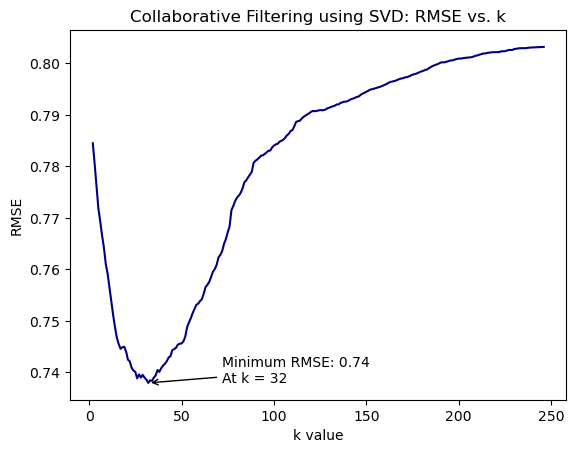

In [151]:
# Visualize RMSE vs k
plt.plot(k_array, val_rmse_list, label = 'Val RMSE', color = 'navy')
plt.title('Collaborative Filtering using SVD: RMSE vs. k')
plt.ylabel('RMSE')
plt.xlabel('k value')

min_rmse = min(val_rmse_list)
min_k = k_array[val_rmse_list.index(min_rmse)]

plt.annotate(f'Minimum RMSE: {min_rmse:.2f}\nAt k = {min_k}',
             xy = (min_k, min_rmse),
             xytext = (min_k + 40, min_rmse),
             arrowprops = dict(facecolor = 'black', arrowstyle = '->'),
             )

plt.show()

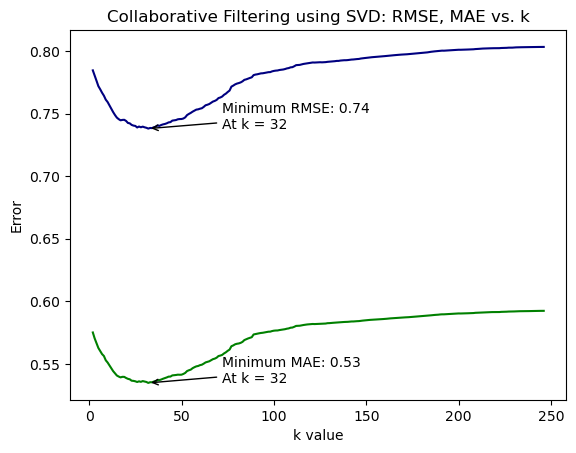

In [154]:
# Visualize RMSE vs k
plt.plot(k_array, val_rmse_list, label = 'Val RMSE', color = 'navy')
plt.plot(k_array, val_mae_list, label = 'Val MAE', color = 'green')
plt.title('Collaborative Filtering using SVD: RMSE, MAE vs. k')
plt.ylabel('Error')
plt.xlabel('k value')

min_rmse = min(val_rmse_list)
min_k = k_array[val_rmse_list.index(min_rmse)]

plt.annotate(f'Minimum RMSE: {min_rmse:.2f}\nAt k = {min_k}',
             xy = (min_k, min_rmse),
             xytext = (min_k + 40, min_rmse),
             arrowprops = dict(facecolor = 'black', arrowstyle = '->'),
             )

min_mae = min(val_mae_list)
min_k = k_array[val_mae_list.index(min_mae)]

plt.annotate(f'Minimum MAE: {min_mae:.2f}\nAt k = {min_k}',
             xy = (min_k, min_mae),
             xytext = (min_k + 40, min_mae),
             arrowprops = dict(facecolor = 'black', arrowstyle = '->'),
             )

plt.show()

## Takeaways:

- The above is unlike what we've seen for the other baseline models. In this model, RMSE does not decay exponentially as we increase the value of k, but rather it declines and hits a minimum around k = 32 before increasing again
- This is interesting as I think we'd expect RMSE to decline as k increases, since a higher value of k basically means that more information from the original matrix is retained, and thus the model should be a better approximation of our data
- My guess is that the model is overfitting with higher values of k, and there's categories in our dataset that are being retained that aren't actually useful. This somewhat ties in with what we saw in the Lasso regression, where the majority of business categories were sent to 0 and weren't helpful in predicting a user's star rating
- It's possible that the reason why we see different behavior here than when the sparsity matrix is based off restaurants v users is because since that matrix is much more sparse, it requires a higher value of k to learn off of, whereas in our case, since our dataset is less sparse, a high value of k isn't necessary.

## Testing with optimal k = 32 on test and validation sets:

### Validation set:

In [157]:
# Perform SVD
U, sigma, Vt = svds(train, k = 32)
sigma = np.diag(sigma)
recalculated_ratings = np.dot(np.dot(U, sigma), Vt)
recalculated_ratings = recalculated_ratings + avg_ratings.values.reshape(-1, 1)

# Create a dataframe from the SVD recalculation 
user_ratings_filled = pd.DataFrame(recalculated_ratings,
                                   index = nola9.index,
                                   columns = nola9.columns)

# 'De-normalize' val set
recalculated_val = np.where(val == 0, None, val + avg_ratings.values.reshape(-1, 1))
recalculated_val = pd.DataFrame(recalculated_val, columns = user_ratings_filled.columns, index = user_ratings_filled.index)

# Get RMSE of validation set
recalculated_val = pd.DataFrame(recalculated_val, columns = user_ratings_filled.columns, index = user_ratings_filled.index)
result = recalculated_val.subtract(user_ratings_filled)**2
rmse = np.sqrt(result.sum().sum() / result.count().sum())
print('RMSE Validation Set:', rmse)

# Get MAE of validation set
result_mae = abs(recalculated_val.subtract(user_ratings_filled))
mae = result_mae.sum().sum() / result.count().sum()
print('MAE Validation Set:', mae)

RMSE Validation Set: 0.7379672711555164
MAE Validation Set: 0.5348359976326873


### Test set:

In [159]:
# Perform SVD
U, sigma, Vt = svds(train, k = 32)
sigma = np.diag(sigma)
recalculated_ratings = np.dot(np.dot(U, sigma), Vt)
recalculated_ratings = recalculated_ratings + avg_ratings.values.reshape(-1, 1)

# Create a dataframe from the SVD recalculation 
user_ratings_filled = pd.DataFrame(recalculated_ratings,
                                   index = nola9.index,
                                   columns = nola9.columns)

# 'De-normalize' test set
recalculated_test = np.where(test == 0, None, test + avg_ratings.values.reshape(-1, 1))
recalculated_test = pd.DataFrame(recalculated_test, columns = user_ratings_filled.columns, index = user_ratings_filled.index)

# Get RMSE of test set
recalculated_test = pd.DataFrame(recalculated_test, columns = user_ratings_filled.columns, index = user_ratings_filled.index)
result = recalculated_test.subtract(user_ratings_filled)**2
rmse = np.sqrt(result.sum().sum() / result.count().sum())
print('RMSE Test Set:', rmse)

# Get MAE of test set
result_mae = abs(recalculated_test.subtract(user_ratings_filled))
mae = result_mae.sum().sum() / result.count().sum()
print('MAE Test Set:', mae)

RMSE Test Set: 0.7397651300506596
MAE Test Set: 0.5334049003000837


## Takeaways:

1. The RMSE and MAE for both the test and validation sets are nearly identical. This indicates that our model isn't over or underfitting

## Finding Similar Users:

In [128]:
from sklearn.metrics.pairwise import cosine_similarity

In [85]:
similarities = cosine_similarity(user_ratings_filled)

In [86]:
cosine_similarity_df = pd.DataFrame(similarities, 
                                    index = user_ratings_filled.index, 
                                    columns = user_ratings_filled.index)

In [129]:
cosine_similarity_df.head()

user_id,-0LGLx8LP5dq3zcGO4Bebw,-13RX4Gy_F-zoLIenWAo-w,-154QAmLwXOsKqChHSeWJQ,-1MiSauypbVtNnWts4aXpA,-22PBmQh7bBWbNX1irrkPQ,-2PIzrbasYWAggcNS2ptGw,-4YEZRxp3TwFKtNlzylx_Q,-6rFcyKGC-B7C89FzLyBeA,-BVK-mFx5n0bPtulAPpXew,-Bo3nX8KSLzUSYVS-6c5Ag,...,zooLE09tPEnZJrJeXe4D4Q,zox0bzk1LvmLb77fmcRjUQ,zpcZzNtQE6vuMekqEV1jYw,zqh6jyBabvzC92bxW2Gjyg,zrESudirjip-s8wxxAB0xw,zta_5JXUGLPv_6szNTE0qQ,zwy1ik1ICsC-Ckzr9BKsvA,zx4c7K-1eBSvEmUg7zqiZQ,zxyKewY6p0CjnFprEutaog,zy0el7c-IO4BvjxUgj-ZSw
user_id,,,,,,,,,,,,,,,,,,,,,
-0LGLx8LP5dq3zcGO4Bebw,1.000000,0.988734,0.988147,0.987057,0.988205,0.983068,0.989340,0.989450,0.988812,0.987154,...,0.980475,0.984702,0.984200,0.989330,0.987800,0.989413,0.987304,0.984221,0.987668,0.976766
-13RX4Gy_F-zoLIenWAo-w,0.988734,1.000000,0.997137,0.994013,0.998757,0.995943,0.997969,0.998795,0.998411,0.997886,...,0.988943,0.997267,0.993417,0.998861,0.998760,0.994557,0.998119,0.996017,0.997444,0.986318
-154QAmLwXOsKqChHSeWJQ,0.988147,0.997137,1.000000,0.993318,0.997796,0.994286,0.997147,0.997926,0.997313,0.997211,...,0.988404,0.996226,0.993295,0.997521,0.997978,0.994404,0.996616,0.994479,0.996111,0.984957
-1MiSauypbVtNnWts4aXpA,0.987057,0.994013,0.993318,1.000000,0.994834,0.990496,0.994649,0.994723,0.994166,0.993552,...,0.984376,0.992576,0.989903,0.994912,0.994564,0.991379,0.993769,0.990445,0.991232,0.988828
-22PBmQh7bBWbNX1irrkPQ,0.988205,0.998757,0.997796,0.994834,1.000000,0.996095,0.998657,0.999252,0.998379,0.998944,...,0.988286,0.998186,0.993935,0.999341,0.999324,0.995197,0.998449,0.995862,0.997573,0.987479


In [121]:
# get top 3 most similar users for random user
cosine_similarity_df.loc['-0LGLx8LP5dq3zcGO4Bebw'].sort_values(ascending = False)[1:4]

user_id
1qbG8LGyMl1_2mlcZwh1Wg    0.991002
2fl7El9b2uxKLwLubyNR1Q    0.990913
s6PTub_2NPSshE6qR9YutA    0.990817
Name: -0LGLx8LP5dq3zcGO4Bebw, dtype: float64

In [131]:
# show category ratings for top 3 most similar users
pd.set_option('display.max_rows', 250)     # Show all rows
nola7.set_index('user_id').loc[['-0LGLx8LP5dq3zcGO4Bebw', '1qbG8LGyMl1_2mlcZwh1Wg',
                               '2fl7El9b2uxKLwLubyNR1Q', 's6PTub_2NPSshE6qR9YutA']].T

user_id,-0LGLx8LP5dq3zcGO4Bebw,1qbG8LGyMl1_2mlcZwh1Wg,2fl7El9b2uxKLwLubyNR1Q,s6PTub_2NPSshE6qR9YutA
Acai Bowls,NaN,NaN,NaN,NaN
Active Life,NaN,NaN,NaN,NaN
Adult Entertainment,NaN,NaN,NaN,NaN
African,NaN,NaN,NaN,NaN
American (New),2.666667,3.333333,4.000000,4.666667
American (Traditional),2.833333,3.666667,3.800000,4.800000
Apartments,NaN,NaN,NaN,NaN
Arabic,NaN,NaN,NaN,NaN
Arcades,NaN,NaN,NaN,NaN
Argentine,NaN,NaN,NaN,NaN


In [167]:
# get 3 least similar users for random user
cosine_similarity_df.loc['-0LGLx8LP5dq3zcGO4Bebw'].sort_values()[1:4]

user_id
nCpTIm3Pij4bre93407ViQ    0.957274
EP8o8JnQSI0WEkeodwA8lA    0.961277
wDmVI9I07DniwYAz8_cBPA    0.961358
Name: -0LGLx8LP5dq3zcGO4Bebw, dtype: float64

In [134]:
# show category ratings for 3 least similar users
pd.set_option('display.max_rows', 250)     # Show all rows
nola7.set_index('user_id').loc[['-0LGLx8LP5dq3zcGO4Bebw', 'nCpTIm3Pij4bre93407ViQ',
                               'EP8o8JnQSI0WEkeodwA8lA', 'wDmVI9I07DniwYAz8_cBPA']].T

user_id,-0LGLx8LP5dq3zcGO4Bebw,nCpTIm3Pij4bre93407ViQ,EP8o8JnQSI0WEkeodwA8lA,wDmVI9I07DniwYAz8_cBPA
Acai Bowls,NaN,NaN,NaN,NaN
Active Life,NaN,1.000000,NaN,NaN
Adult Entertainment,NaN,NaN,NaN,NaN
African,NaN,NaN,1.000000,NaN
American (New),2.666667,4.000000,2.846154,2.000000
American (Traditional),2.833333,5.000000,2.500000,5.000000
Apartments,NaN,NaN,NaN,NaN
Arabic,NaN,NaN,NaN,NaN
Arcades,NaN,NaN,NaN,NaN
Argentine,NaN,NaN,NaN,NaN


## Takeaways:

1. Obviously these are just the similarities of one user, but based on the original matrix of rankings, it's not terribly surprising what these outcomes are. The least similar users had fairly different ratings for Cafes, Caterers, Mexican and Breakfast & Brunch restaurants compared to our 'main' user. Additionally, the top 3 similar users had fairly similar ratings for Bars, Cafes, Event Planning & Services and Live/Raw food compared to our 'main' user.
2. My biggest concern is how similar most of the users are to eachother, the most similar user was ~0.99 and the least similar user is ~0.96, which seems like an overall pretty minor difference. This isn't too surprising given that most users had fairly high restaurant ratings overall. This makes me think that I probably should have incorporated some kind of weighted average to take into account the number of restaurants that a user had rated with each category tag, but alas.

## Generating restaurant recommendations based on the similarity matrix

1. Identify top three most similar users
2. Take users top 5 highly rated categories, and take average of similar users ratings in those top 5 categories
3. Look in original dataframe for restaurants in these top 5 categories that the top 3 most similar users have rated
4. Filter out closed restaurants and restaurants the user of interest has already rated
5. Take average rating of the remaining restaurants across the top 3 users
6. Return top n restaurants

In [344]:
def restaurant_recs(user, cosine_similarity, num_recs):
    # top 3 most similar users
    top_users = cosine_similarity_df.loc[user].sort_values(ascending = False)[0:4].index.tolist()
    
    # top averaged categories
    top5cat = user_ratings_filled.loc[top_users].mean().sort_values(ascending = False)[0:5].index.tolist()
    
    # identify restaurants user has already been to
    already_visited = nola2[nola2['user_id'] == user]['business_id'].tolist()
    
    # get restaurant options
    similar_restaurants_df = nola2[(nola2['user_id'].isin(top_users[1:])) &
                                   (nola2['categories'].str.contains('|'.join(str(cat) for cat in top5cat))) &
                                   (nola2['is_open'] == 1) &
                                   (~nola2['business_id'].isin(already_visited))][['business_id', 'name', 'categories', 'user_id', 'userRating']]

    # get top n restaurants
    topn = similar_restaurants_df.groupby(['business_id', 'name', 'categories'], as_index = False) \
                             .mean() \
                             .sort_values('userRating', ascending = False)[0:num_recs] \
                             .reset_index()
    
    return topn[['name', 'categories']]

In [346]:
restaurant_recs(user = '-0LGLx8LP5dq3zcGO4Bebw', cosine_similarity = cosine_similarity_df, num_recs = 5)

,name,categories
0,Restaurant Rebirth,"Cajun/Creole, Soup, Seafood, Restaurants, Stea..."
1,GW Fins,"Seafood, Gluten-Free, Vegetarian, Restaurants"
2,Restaurant August,"Cajun/Creole, American (New), Restaurants, French"
3,Emeril's Delmonico,"Restaurants, American (New), Cajun/Creole, Bar..."
4,District Donuts Sliders & Brew Lakeview,"Restaurants, Donuts, Breakfast & Brunch, Coffe..."


In [351]:
restaurant_recs(user = 'wDmVI9I07DniwYAz8_cBPA', cosine_similarity = cosine_similarity_df, num_recs = 5)

/var/folders/w3/x0690xnx12bcnwv0x7n6s4q00000gn/T/ipykernel_11211/2737974313.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  (nola2['categories'].str.contains('|'.join(str(cat) for cat in top5cat))) &


,name,categories
0,Cafe Sbisa,"Nightlife, Southern, Seafood, Cajun/Creole, Ba..."
1,New Orleans Hamburger & Seafood Co,"Restaurants, American (Traditional), Seafood, ..."
2,Russell's Marina Grill,"Breakfast & Brunch, Restaurants, Seafood, Burg..."
3,Creole House Restaurant & Oyster Bar,"Cajun/Creole, Seafood, Restaurants, Breakfast ..."
4,Cochon,"Cajun/Creole, Seafood, Restaurants"
